In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

from dataloader import CustomImageDataset
from torch.utils.data import DataLoader, random_split


In [4]:
# Define the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize to 224x224
    transforms.ToTensor()
])

# Create the dataset and dataloader

class_to_idx = {'sma': 1, 'non-sma': 0}

# Get current directory
current_directory = os.getcwd()

# Relative directory of images
other_string = "Red_Cell_Morphology 3"
# Combine directpries
new_path = os.path.join(current_directory, other_string)

# Create dataset
dataset = CustomImageDataset(root_dir=new_path, class_to_idx=class_to_idx, transform=transform)

# Define the train, validation, and test ratios (e.g., 70%, 15%, 15%)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the number of samples for each split
num_samples = len(dataset)
train_samples = int(train_ratio * num_samples)
val_samples = int(val_ratio * num_samples)
test_samples = num_samples - train_samples - val_samples

# Use random_split to split the dataset
train_set, val_set, test_set = random_split(dataset, [train_samples, val_samples, test_samples])

# Create data loaders for each split
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)  # No need to shuffle validation set
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)  # No need to shuffle test set


In [5]:
# Get counts
counts = dataset.get_class_counts()
print(counts)

{'sma': 33, 'non-sma': 33}


Class: non-SMA, Number of images: 10


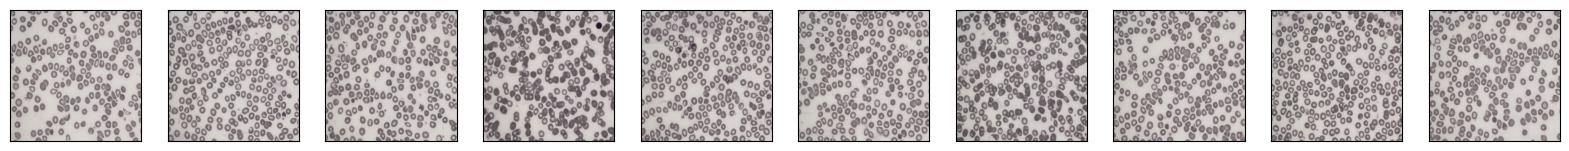

In [4]:
# Fetch first bag from the DataLoader
images, label = next(iter(train_loader))

print(f"Class: {'SMA' if label.item()==1 else 'non-SMA'}, Number of images: {len(images)}")

# Display all images from this bag
fig = plt.figure(figsize=(20, 10))  # adjust size as needed
for i in range(len(images)):
    ax = fig.add_subplot(1, len(images), i+1, xticks=[], yticks=[])
    img = images[i].squeeze().permute(1, 2, 0)  
    ax.imshow(img.numpy())
plt.show()

In [6]:
# Iterate through the data loader
for images, label in train_loader:
    # Iterate through each image in the bag
    for i in range(len(images[0])):
        print(f"Image {i+1} dimensions: {images[i].size()}")

Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])


KeyboardInterrupt: 

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 500)  # Adjusted for input image size 224x224
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # Perform individual feature extraction on each image
        features = []
        for img in x:
            img_features = self.pool(F.relu(self.conv1(img)))
            img_features = self.pool(F.relu(self.conv2(img_features)))            
            img_features = img_features.view(img_features.size(0), -1)  # Flatten layer
            img_features = F.relu(self.fc1(img_features))
            img_features = self.fc2(img_features)
            features.append(img_features)

        # Apply max pooling across all images
        pooled_features = torch.stack(features)
        # print(pooled_features.size())
        pooled_features, _ = torch.max(pooled_features, dim=0)
        # print(pooled_features.size())

        # Flatten the pooled features
        x = pooled_features.view(pooled_features.size(0), -1)

        # Pass through the fully connected layers
        x = self.fc3(x)
        x = self.sigmoid(x)  # Apply sigmoid activation

        return x

In [8]:
# Initialize the network and optimizer
net = SimpleCNN()
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.000001)

# Function to perform max pooling over feature vectors
def max_pool_feature_vectors(feature_vectors):
    return torch.max(feature_vectors, 0)[0]

# Calculate class frequencies
# class_0_count = 110  # Number of samples in class 0
# class_1_count = 33  # Number of samples in class 1

# # Calculate class weights
# total_count = class_0_count + class_1_count
# class_0_weight = total_count / (2 * class_0_count)
# class_1_weight = total_count / (2 * class_1_count)

# weight=torch.tensor([class_1_weight])
# print(weight)

# Initialize lists to store accuracy values
train_accuracy_list = []
val_accuracy_list = []
test_accuracy = 0.0       

# Training loop
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader),desc=f'Epoch {epoch+1}/{1}', unit='batch',) as pbar:
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # print(len(inputs))
            # print(inputs[0].size()) # Len n images of size [1,3,224,224]
            # print(labels) # Tensor scalar
            
            target = net(inputs)
            print('actual label: ', labels)

            print('target: ', target)
            # target = torch.round(target,1)
            objective = loss(target[0],labels.float())
            objective.backward()
            optimizer.step()
            

            # Update accuracy
            predicted = target.data.round().int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # print statistics
            running_loss += objective.item()
            
             # Print loss in every minibatch
            print(f'Epoch {epoch+1}/{1}, Minibatch {i+1}/{len(train_loader)}, Loss: {objective.item()}')
            pbar.update(1)

    # Calculate training accuracy
    train_accuracy = 100 * correct / total
    train_accuracy_list.append(train_accuracy)

    # Validation accuracy
    net.eval()  # Switch to evaluation mode
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            target = net(inputs)

            # Calculate validation accuracy
            predicted = target.data.round().int()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_accuracy_list.append(val_accuracy)

# Testing accuracy
net.eval()  # Switch to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        target = net(inputs)

        # Calculate test accuracy
        predicted = target.data.round().int()
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total

print(f'Training Accuracy: {train_accuracy_list[-1]:.2f}%')
print(f'Validation Accuracy: {val_accuracy_list[-1]:.2f}%')
print(f'Test Accuracy: {test_accuracy:.2f}%')

print('Finished Training')


Epoch 1/1:   0%|          | 0/46 [00:00<?, ?batch/s]

actual label:  tensor([0])
target:  tensor([[0.5130]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:   2%|▏         | 1/46 [00:04<03:03,  4.07s/batch]

Epoch 1/1, Minibatch 1/46, Loss: 0.9822059869766235
actual label:  tensor([1])
target:  tensor([[0.4910]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:   4%|▍         | 2/46 [00:07<02:48,  3.82s/batch]

Epoch 1/1, Minibatch 2/46, Loss: 0.47748079895973206
actual label:  tensor([0])
target:  tensor([[0.4731]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:   7%|▋         | 3/46 [00:10<02:32,  3.55s/batch]

Epoch 1/1, Minibatch 3/46, Loss: 0.9574429988861084
actual label:  tensor([1])
target:  tensor([[0.4647]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:   9%|▊         | 4/46 [00:13<02:09,  3.08s/batch]

Epoch 1/1, Minibatch 4/46, Loss: 0.4875456392765045
actual label:  tensor([0])
target:  tensor([[0.4494]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  11%|█         | 5/46 [00:17<02:21,  3.45s/batch]

Epoch 1/1, Minibatch 5/46, Loss: 0.9428688883781433
actual label:  tensor([1])
target:  tensor([[0.4236]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  13%|█▎        | 6/46 [00:20<02:15,  3.38s/batch]

Epoch 1/1, Minibatch 6/46, Loss: 0.5036069750785828
actual label:  tensor([0])
target:  tensor([[0.4275]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  15%|█▌        | 7/46 [00:23<02:11,  3.36s/batch]

Epoch 1/1, Minibatch 7/46, Loss: 0.9295605421066284
actual label:  tensor([1])
target:  tensor([[0.4016]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  17%|█▋        | 8/46 [00:27<02:07,  3.35s/batch]

Epoch 1/1, Minibatch 8/46, Loss: 0.5123641490936279
actual label:  tensor([0])
target:  tensor([[0.3946]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  20%|█▉        | 9/46 [00:29<01:47,  2.91s/batch]

Epoch 1/1, Minibatch 9/46, Loss: 0.909813404083252
actual label:  tensor([0])
target:  tensor([[0.3756]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  22%|██▏       | 10/46 [00:32<01:47,  2.99s/batch]

Epoch 1/1, Minibatch 10/46, Loss: 0.8984799385070801
actual label:  tensor([1])
target:  tensor([[0.3782]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  24%|██▍       | 11/46 [00:36<01:56,  3.32s/batch]

Epoch 1/1, Minibatch 11/46, Loss: 0.521837055683136
actual label:  tensor([1])
target:  tensor([[0.3554]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  26%|██▌       | 12/46 [00:43<02:29,  4.40s/batch]

Epoch 1/1, Minibatch 12/46, Loss: 0.5311679244041443
actual label:  tensor([0])
target:  tensor([[0.3437]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  28%|██▊       | 13/46 [00:46<02:14,  4.08s/batch]

Epoch 1/1, Minibatch 13/46, Loss: 0.8797125816345215
actual label:  tensor([1])
target:  tensor([[0.3316]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  30%|███       | 14/46 [00:51<02:17,  4.30s/batch]

Epoch 1/1, Minibatch 14/46, Loss: 0.5410296320915222
actual label:  tensor([0])
target:  tensor([[0.3402]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  33%|███▎      | 15/46 [00:55<02:12,  4.28s/batch]

Epoch 1/1, Minibatch 15/46, Loss: 0.877618670463562
actual label:  tensor([0])
target:  tensor([[0.3119]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  35%|███▍      | 16/46 [00:58<01:55,  3.86s/batch]

Epoch 1/1, Minibatch 16/46, Loss: 0.8611904382705688
actual label:  tensor([0])
target:  tensor([[0.3101]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  37%|███▋      | 17/46 [01:05<02:19,  4.81s/batch]

Epoch 1/1, Minibatch 17/46, Loss: 0.8601833581924438
actual label:  tensor([1])
target:  tensor([[0.2843]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  39%|███▉      | 18/46 [01:08<01:57,  4.21s/batch]

Epoch 1/1, Minibatch 18/46, Loss: 0.5610597133636475
actual label:  tensor([1])
target:  tensor([[0.2915]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  41%|████▏     | 19/46 [01:11<01:43,  3.83s/batch]

Epoch 1/1, Minibatch 19/46, Loss: 0.5579769611358643
actual label:  tensor([0])
target:  tensor([[0.2767]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  43%|████▎     | 20/46 [01:16<01:46,  4.10s/batch]

Epoch 1/1, Minibatch 20/46, Loss: 0.841036319732666
actual label:  tensor([0])
target:  tensor([[0.2647]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  46%|████▌     | 21/46 [01:23<02:03,  4.94s/batch]

Epoch 1/1, Minibatch 21/46, Loss: 0.8342269062995911
actual label:  tensor([0])
target:  tensor([[0.2434]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  48%|████▊     | 22/46 [01:26<01:49,  4.57s/batch]

Epoch 1/1, Minibatch 22/46, Loss: 0.8222419619560242
actual label:  tensor([1])
target:  tensor([[0.2341]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  50%|█████     | 23/46 [01:29<01:33,  4.09s/batch]

Epoch 1/1, Minibatch 23/46, Loss: 0.5829127430915833
actual label:  tensor([1])
target:  tensor([[0.2425]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  52%|█████▏    | 24/46 [01:35<01:38,  4.46s/batch]

Epoch 1/1, Minibatch 24/46, Loss: 0.5792206525802612
actual label:  tensor([0])
target:  tensor([[0.2224]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  54%|█████▍    | 25/46 [01:38<01:27,  4.17s/batch]

Epoch 1/1, Minibatch 25/46, Loss: 0.8105438351631165
actual label:  tensor([1])
target:  tensor([[0.2143]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  57%|█████▋    | 26/46 [01:42<01:22,  4.13s/batch]

Epoch 1/1, Minibatch 26/46, Loss: 0.5917316675186157
actual label:  tensor([0])
target:  tensor([[0.2038]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  59%|█████▊    | 27/46 [01:47<01:21,  4.29s/batch]

Epoch 1/1, Minibatch 27/46, Loss: 0.8002438545227051
actual label:  tensor([1])
target:  tensor([[0.2084]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  61%|██████    | 28/46 [01:51<01:18,  4.39s/batch]

Epoch 1/1, Minibatch 28/46, Loss: 0.5943588018417358
actual label:  tensor([1])
target:  tensor([[0.1832]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  63%|██████▎   | 29/46 [01:55<01:13,  4.30s/batch]

Epoch 1/1, Minibatch 29/46, Loss: 0.6057470440864563
actual label:  tensor([0])
target:  tensor([[0.1654]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  65%|██████▌   | 30/46 [02:00<01:09,  4.33s/batch]

Epoch 1/1, Minibatch 30/46, Loss: 0.7792730331420898
actual label:  tensor([1])
target:  tensor([[0.1596]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  67%|██████▋   | 31/46 [02:06<01:11,  4.75s/batch]

Epoch 1/1, Minibatch 31/46, Loss: 0.6165486574172974
actual label:  tensor([0])
target:  tensor([[0.1645]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  70%|██████▉   | 32/46 [02:08<00:56,  4.04s/batch]

Epoch 1/1, Minibatch 32/46, Loss: 0.7787681818008423
actual label:  tensor([0])
target:  tensor([[0.1608]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  72%|███████▏  | 33/46 [02:13<00:55,  4.24s/batch]

Epoch 1/1, Minibatch 33/46, Loss: 0.7767815589904785
actual label:  tensor([1])
target:  tensor([[0.1456]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  74%|███████▍  | 34/46 [02:16<00:47,  3.99s/batch]

Epoch 1/1, Minibatch 34/46, Loss: 0.6230128407478333
actual label:  tensor([1])
target:  tensor([[0.1366]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  76%|███████▌  | 35/46 [02:21<00:46,  4.22s/batch]

Epoch 1/1, Minibatch 35/46, Loss: 0.6271755695343018
actual label:  tensor([0])
target:  tensor([[0.1394]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  78%|███████▊  | 36/46 [02:28<00:50,  5.02s/batch]

Epoch 1/1, Minibatch 36/46, Loss: 0.7652509808540344
actual label:  tensor([1])
target:  tensor([[0.1346]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  80%|████████  | 37/46 [02:31<00:39,  4.41s/batch]

Epoch 1/1, Minibatch 37/46, Loss: 0.6280925273895264
actual label:  tensor([0])
target:  tensor([[0.1183]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  80%|████████  | 37/46 [02:36<00:37,  4.22s/batch]


KeyboardInterrupt: 

In [32]:
test_total=0
test_correct=0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        target = net(inputs)
        print('target', target)
        print('labels: ', labels)

        # Calculate test accuracy
        print('target data:' , target.data)
        predicted = target.data.round().int()
        print('predicted', predicted)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(test_accuracy)

target tensor([[0.8240]])
labels:  tensor([1])
target data: tensor([[0.8240]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8167]])
labels:  tensor([1])
target data: tensor([[0.8167]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8113]])
labels:  tensor([1])
target data: tensor([[0.8113]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8184]])
labels:  tensor([1])
target data: tensor([[0.8184]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8050]])
labels:  tensor([1])
target data: tensor([[0.8050]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8205]])
labels:  tensor([1])
target data: tensor([[0.8205]])
predicted tensor([[1]], dtype=torch.int32)
100.0
